In [1]:
import numpy as np
import pandas as pd
from tqdm import trange
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import jieba.analyse
import jieba
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
# from sklearn.decomposition import PCA

In [2]:
# 读取数据
data = pd.read_csv('data/xmc.tsv', delimiter='\t')  #dxy_foreign
data = data['title'].str.cat(data['desc'], sep=' ')
data = [str(i).strip() for i in data.values.tolist()]

In [4]:
'''基于Bert的文本向量化表示'''
from sentence_transformers import SentenceTransformer

bert_encoder = SentenceTransformer('/home/pgrad/LinLitao/PLMs/sentence-transformersparaphrase-multilingual-mpnet-base-v2')
# sentence-transformers/paraphrase-multilingual-mpnet-base-v2 # dim:768,max_len:128
X = bert_encoder.encode(data)  # 返回值是numpy类型
# 看一下处理后数据的维度
X.shape

(9341, 768)

In [5]:
# 如需对聚类结果画图，运行此单元格
svd = TruncatedSVD(2)  #设置降维后的维度
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

In [6]:
# 用不同指标绘制学习曲线找出最优类别数，参考https://www.jianshu.com/p/6ff067b9e2ba
class_silscore = []  #轮廓系数，越大越好
sse = []  # 误差平方和
ch = []  # calinski_harabasz_score，簇间距离与簇内样本数据之间聚类的比值，CH指数越大，聚类效果越好
for n_clusters in trange(2, 12):  # 设置可接受的类别数量范围，如2类到9类
    clusters = KMeans(n_clusters=n_clusters, init='k-means++').fit(X)
    silhouette_avg = silhouette_score(X, clusters.labels_)
    class_silscore.append([n_clusters, silhouette_avg])
    sse.append([n_clusters, clusters.inertia_])
    ch.append([n_clusters, calinski_harabasz_score(X, clusters.labels_)])
    # sample_silhouette_values = silhouette_samples(X, clusters.labels_)
df_class_silscore = pd.DataFrame(class_silscore, columns=['num_clusters', 'avg_silhouette_score'])
df_calinski_harabasz_score = pd.DataFrame(ch, columns=['num_clusters', 'calinski_harabasz_score'])
df_sse = pd.DataFrame(sse, columns=['num_clusters', 'SSE'])

100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


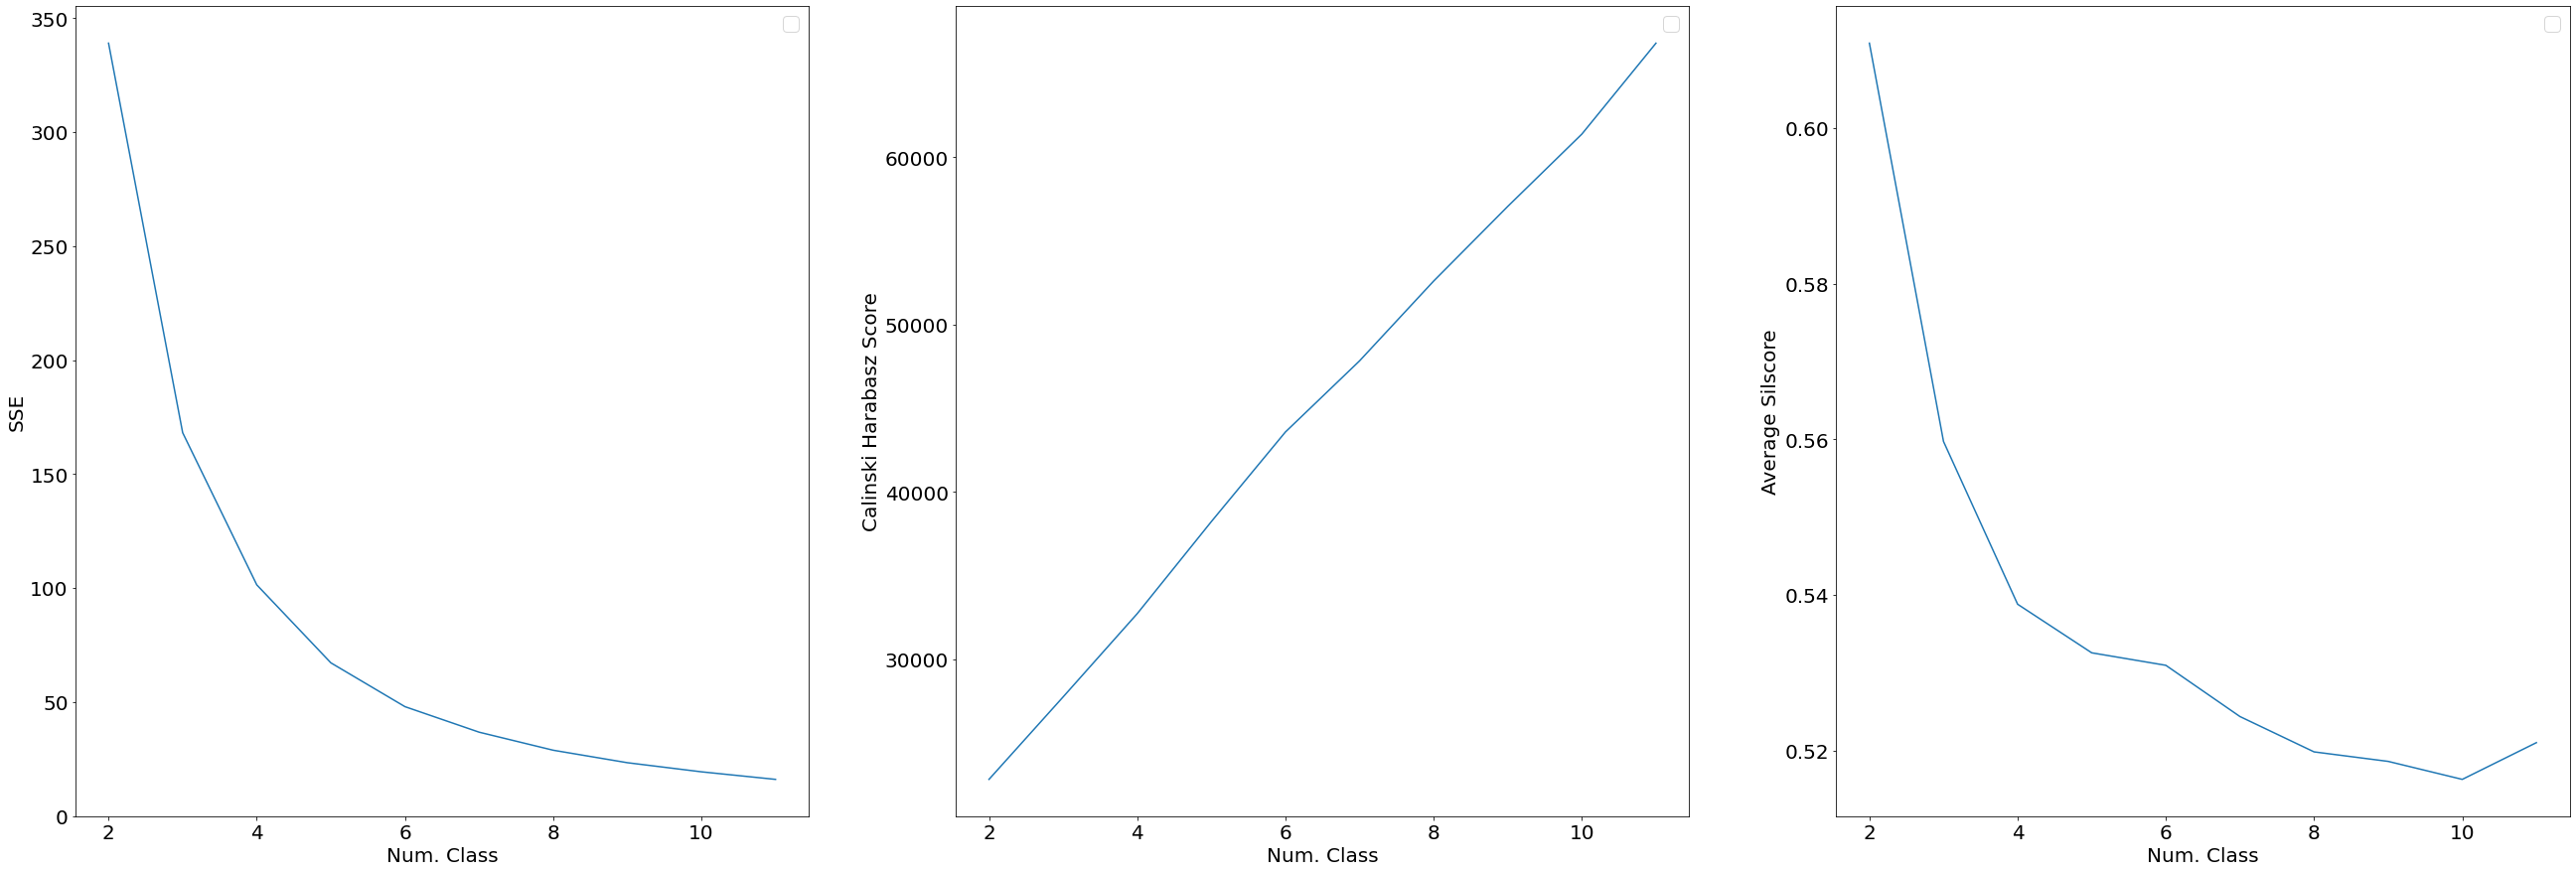

In [26]:
# 画图
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(45, 15))
plt.subplot(131) # plt.subplot(222)表示将整个图像窗口分为2行2列, 当前位置为2
# plt.title('SSE')
plt.plot(df_sse['num_clusters'], df_sse['SSE'])
plt.xlabel('Num. Class')
plt.ylabel('SSE')
plt.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['axes.unicode_minus'] = False
plt.legend(loc='best')

plt.subplot(132)
# plt.title('Calinski Harabasz Score')
plt.plot(df_calinski_harabasz_score['num_clusters'], df_calinski_harabasz_score['calinski_harabasz_score'])
plt.xlabel('Num. Class')
plt.ylabel('Calinski Harabasz Score')
plt.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['axes.unicode_minus'] = False
plt.legend(loc='best')

plt.subplot(133)
# plt.title('Average Silscore')
plt.plot(df_class_silscore['num_clusters'], df_class_silscore['avg_silhouette_score'])
plt.xlabel('Num. Class')
plt.ylabel('Average Silscore')
plt.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['axes.unicode_minus'] = False
plt.legend(loc='best')
plt.show()

In [10]:
# df_class_silscore.to_excel('clustered_out/silscore_xmc.xlsx')
pd.concat([df_calinski_harabasz_score, df_class_silscore, df_sse], axis=1).to_excel(
    'clustered_out/clustereval_xmc.xlsx')

In [11]:
'''使用最优类别数进行聚类'''
max_silscore_idx = df_class_silscore['avg_silhouette_score'].idxmax()  # 获得最大轮廓系数对应的最优类簇数
best_k = df_class_silscore['num_clusters'].iloc[max_silscore_idx]
num_cluster = best_k  # 填入上一步输出的最大平均轮廓系数对应的类别数
best_clusters = KMeans(n_clusters=num_cluster, random_state=10).fit(X)  # 获得最优聚类结果
labels = best_clusters.labels_.tolist()  #获得每条原始文本聚类后归入的类别标签
df_clusters = pd.concat([pd.DataFrame(labels, columns=['cluster_id']), pd.DataFrame(data, columns=['text'])], axis=1)
df_clusters.to_excel('clustered_out/bert-kmeans-clustered_xmc.xlsx')  # 输出每个文本及其聚类后归入的类别

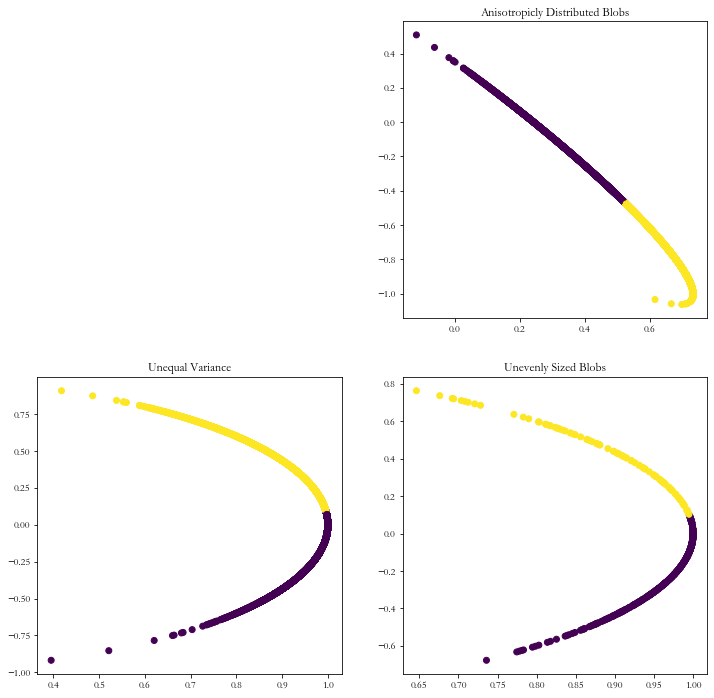

In [49]:
plt.figure(figsize=(12, 12))
plt.rcParams['font.sans-serif'] = ['STSong']
# Incorrect number of clusters
# plt.subplots(221)
# plt.scatter(X[:, 0], X[:, 1], c=best_clusters.labels_)
# plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
plt.subplot(222)
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=num_cluster, random_state=10).fit_predict(X_aniso)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
plt.subplot(223)
plt.scatter(X[:, 0], X[:, 1], c=best_clusters.labels_)
plt.title("Unequal Variance")

# Unevenly sized blobs
plt.subplot(224)
X_filtered = np.vstack(
    (X[best_clusters.labels_ == 0][:500],
     X[best_clusters.labels_ == 1][:100],
     X[best_clusters.labels_ == 2][:10]))
y_pred = KMeans(n_clusters=num_cluster, random_state=10).fit_predict(X_filtered)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")
plt.show()

In [ ]:
'''获得每个类簇的包含的原始文本'''
cluster_text = {}
for i in range(num_cluster):
    cluster_text[i] = []
    for j in np.where(best_clusters.labels_ == i)[0].tolist():
        cluster_text[i] += data[j]  # TODO:完善提取关键词的流程，如去停用词、 同义词归一化等。
    cluster_text[i] = ''.join(cluster_text[i])
'''输出每个类簇中TF-IDF关键词'''
for i in range(num_cluster):
    keywords = jieba.analyse.extract_tags(cluster_text[i], topK=100, allowPOS=())
    with open('keywords-cluster@{}.txt'.format(i), 'w', encoding='utf-8') as f:
        for j in keywords:
            f.write(j + '\n')